**Supervised Text Classification for Marketing Analytics Final Project**

*DTSA 5798*

<br>

---

<br>

**Project Overview**

1. Introduction

2. Setup

3. Exploratory Data Analysis (EDA)

4. Data Cleaning

5. Model Building

6. Model Training

7. Model Validation

8. Model Evaluation

9. Results and Conclusion

<br>

---

# 1. Introduction

**Project Description**

Chrishare, a media buying company, have just acquired a new client, [Theragun](https://www.therabody.com/us/en-us/4th-generation-devices/).

Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. So, they’d like to find health and wellness news around the web to advertise on. Their goal with their media campaign is to identify as many news articles that mention health and wellness as possible.

Contextual advertising is an important aspect of digital advertising. Companies like [Oracle Data Cloud](https://www.oracle.com/cx/advertising/contextual-intelligence/) have solutions that allow advertisers to advertise on web pages that match specific types of content.

Instead of using unsupervised machine learning, which we've learned is less than perfect, we're using supervised machine learning, specifically deep learning.

At the core of the best contextual advertising solutions in the world, there’s a deep learning algorithm labeling articles.

<br>

---

<br>

**Project Objective**

Build a deep learning algorithm that predicts the probability that a news story is about health and wellness using the [k-train](https://github.com/amaiya/ktrain), which is a wrapper for [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/all_symbols), [Keras](https://keras.io/getting_started/), and [Huggingface Transformers](https://github.com/huggingface/transformers).

<br>

---

<br>

**Data Description**

The [dataset](https://d3c33hcgiwev3.cloudfront.net/y__VHyJ0SgCIcxd9tNhazg_695452701c3c435691238d1b1c0016f1_news_category_trainingdata.json?Expires=1705795200&Signature=fpsPLq8WLPgiJCGXX~EUiTlayV8Ct0~BeQpUgPOEe44XT9B0fgtqf2RvjgyXGpfcRnLi8t~uFKP7jr~2M8ZLIeeDbqYmLu5IOC9MzVtuA-Nueza0MnPu3~Pqya8u5rrbNmfklPkxJWiFnA64ugp7t0~085KccT28ukevBDHrJZ0_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A) contains around 200k news headlines from the year 2012 to 2018 obtained from [HuffPost](https://www.huffpost.com/). The model trained on this dataset could be used to identify tags for untracked news articles or to identify the type of language used in different news articles. Each news headline has a corresponding category.


# 2. Setup

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer

import ktrain
from ktrain import text as ktext

import re
import nltk
import nltk.corpus
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('brown')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


# 3. Exploratory Data Analysis (EDA)

## Load Data

In [4]:
url = 'https://d3c33hcgiwev3.cloudfront.net/y__VHyJ0SgCIcxd9tNhazg_695452701c3c435691238d1b1c0016f1_news_category_trainingdata.json?Expires=1706054400&Signature=E-mCF8YXNu7h1GDqmAyS9baOr6vBYyNTB~fOTer5A4GCWK6mNONDIBs79oZLfaJx4Lvz0fLfY8JZFXX9zfGBHEibLV25wtkuZOmHrnPQv1q7FpqTh9s-umhgyoeIZZ4MquLgAtwKnDAahiZegRbBmME3HWK5dLjO2oGP5TUDzkA_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A'
df = pd.read_json(url)

Preview dataset.

In [5]:
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


List unique categories.

In [7]:
display(sorted(set(df.category.unique().tolist())))
print(len(df.category.unique())) # total number of categories

['ARTS',
 'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COLLEGE',
 'COMEDY',
 'CRIME',
 'CULTURE & ARTS',
 'DIVORCE',
 'EDUCATION',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'PARENTS',
 'POLITICS',
 'QUEER VOICES',
 'RELIGION',
 'SCIENCE',
 'SPORTS',
 'STYLE',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'TRAVEL',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLD NEWS',
 'WORLDPOST']

41


There are 2 wellness categories in the data: `HEALTHY LIVING` and `WELLNESS`.

## Data Preprocessing
Combine `headline` and `short_description` variables into single text variable.

In [8]:
df['full_text'] = df['headline'] + ' ' + df['short_description']
df.head()

,category,headline,authors,link,short_description,date,full_text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...


## Data Distributions

* Top 10 Categories

* Wellness vs. Non-Wellness

* Text Length

* Word Count

### Top 10 Categories
Plot top 10 categories in data.

Text(0.5, 1.0, 'Top 10 Categories')

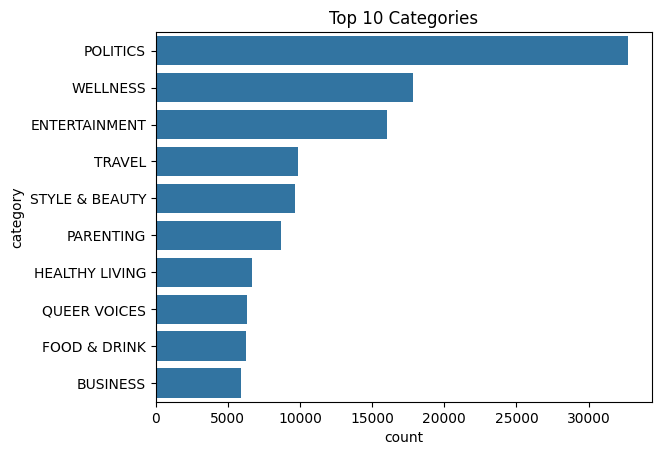

In [9]:
sns.countplot(y="category", data=df,
              order=df.category.value_counts().iloc[:10].index).set_title('Top 10 Categories')

### Wellness vs. Non-Wellness
Plot distribution of wellness vs. non-wellness categories.

In [10]:
# Flag wellness categories
## 0 = Non-Wellness; 1 = Wellness
well_cat = ['HEALTHY LIVING', 'WELLNESS']
df['wellness'] = np.where((df['category'].isin(well_cat)), 1, 0)

df.head()

,category,headline,authors,link,short_description,date,full_text,wellness
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


Text(0, 0.5, 'Category')

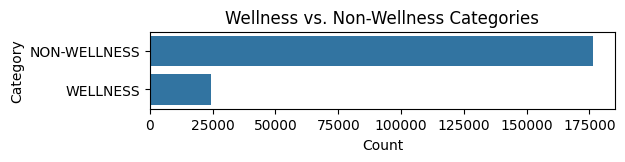

In [11]:
# Count wellness vs. non-wellness categories
well_counts = pd.DataFrame({'category': ['NON-WELLNESS', 'WELLNESS'], 'count': df.wellness.value_counts()})

# Plot distribution
plt.figure(figsize=(6, 1))
sns.barplot(x = 'count', y = 'category', data = well_counts).set_title('Wellness vs. Non-Wellness Categories')
plt.xlabel('Count')
plt.ylabel('Category')

The count plot of wellness vs. non-wellness categories shows that the data is greatly unbalanced in favor of non-wellness categories. We will sample an equal number of wellness and non-wellness categories from the data in order to balance the classes and maintain the distribution.

### Text Length
Plot distribution of text lengths.

In [12]:
# Add text length variable
df['text_length'] = df['full_text'].apply(len)
df.head()

,category,headline,authors,link,short_description,date,full_text,wellness,text_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,141
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,100
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0,135
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0,156
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0,159


Text(0, 0.5, 'Article Count')

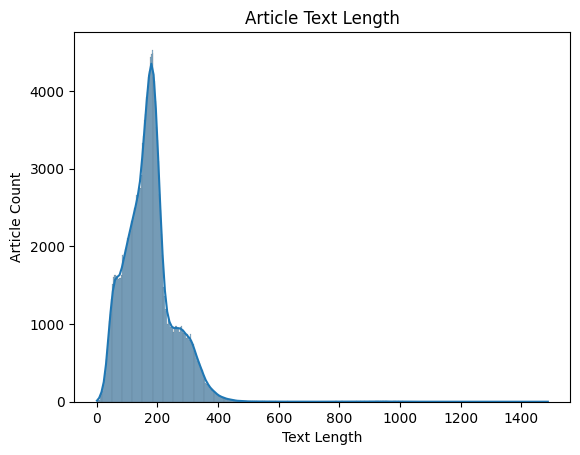

In [13]:
# Plot distribution - histogram
sns.histplot(x = df['text_length'], kde=True).set_title('Article Text Length')
plt.xlabel('Text Length')
plt.ylabel('Article Count')

Text(0.5, 0, 'Text Length')

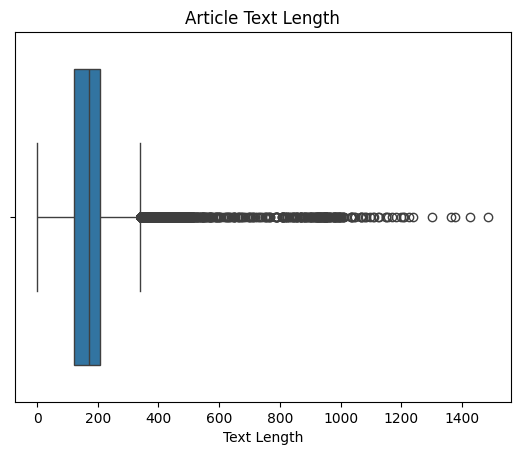

In [14]:
# Plot distribution - boxplot
sns.boxplot(x = df['text_length']).set_title('Article Text Length')
plt.xlabel('Text Length')

### Word Count
Plot distribution of word counts.

In [15]:
# Add word count variable
df['word_count'] = df.apply(lambda row: nltk.word_tokenize(row['full_text']), axis=1).apply(len)
df.head()

,category,headline,authors,link,short_description,date,full_text,wellness,text_length,word_count
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,141,31
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,100,22
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0,135,26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0,156,27
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0,159,32


Text(0, 0.5, 'Article Count')

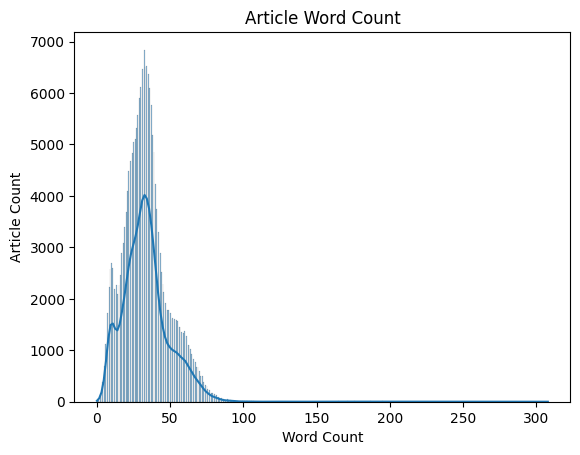

In [16]:
# Plot distribution - histogram
sns.histplot(x = df['word_count'], kde=True).set_title('Article Word Count')
plt.xlabel('Word Count')
plt.ylabel('Article Count')

Text(0.5, 0, 'Word Count')

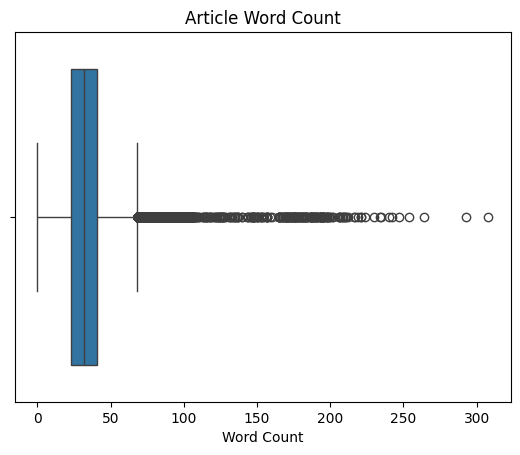

In [17]:
# Plot distribution - boxplot
sns.boxplot(x = df['word_count']).set_title('Article Word Count')
plt.xlabel('Word Count')

# 4. Data Cleaning

* Missing Data

* Text Cleaning

* Tokenization

* Data Sampling

## Missing Data
Check for missing data and remove if necessary.

In [18]:
# Check for null and missing values
pd.concat([df.isnull().sum(), df.eq('').sum()], keys = ['Nulls','Empty'], axis = 1)

,Nulls,Empty
category,0,0
headline,0,6
authors,0,36620
link,0,0
short_description,0,19712
date,0,0
full_text,0,0
wellness,0,0
text_length,0,0
word_count,0,0


Remove rows that are empty in `headline` and `short_description`.

In [19]:
# Remove empty `headline` rows
df = df[df['headline'].astype(bool)]

# Remove empty `short_description` rows
df = df[df['short_description'].astype(bool)]

In [20]:
# Check dataframe
df.eq('').sum()

category                 0
headline                 0
authors              32157
link                     0
short_description        0
date                     0
full_text                0
wellness                 0
text_length              0
word_count               0
dtype: int64

## Text Cleaning
Remove punctuation, numbers, stop words, and extra whitespace.

In [21]:
# Text cleaning function
def clean_text(df, text_col):
    # Convert to lowercase
    df['lowercase'] = df[text_col].str.lower()
    # Remove punctuation
    df['no_punct'] = df['lowercase'].apply(
        lambda row: re.sub(r'[^\w\s]+', '', row))
    # Remove numbers
    df['no_punct_num'] = df['no_punct'].apply(
        lambda row: re.sub(r'[0-9]+', '', row))
    # Remove stopwords
    stop_words = stopwords.words('english')
    df['no_stopwords'] = df['no_punct_num'].apply(
        lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    # Remove extra whitespace
    df['clean_text'] = df['no_stopwords'].apply(
        lambda x: re.sub(' +', ' ', x))

    # Drop helper columns
    df.drop(columns = ['lowercase', 'no_punct','no_punct_num','no_stopwords'], inplace = True)
    return

In [22]:
# Clean text
clean_text(df = df, text_col = 'full_text')
df.head()

,category,headline,authors,link,short_description,date,full_text,wellness,text_length,word_count,clean_text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,141,31,mass shootings texas last week tv left husband...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,100,22,smith joins diplo nicky jam world cups officia...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0,135,26,hugh grant marries first time age actor longti...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0,156,27,jim carrey blasts castrato adam schiff democra...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0,159,32,julianna margulies uses donald trump poop bags...


## Tokenization

In [23]:
# Function for text tokenization
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
    lem = [wordnet_lemmatizer.lemmatize(word.lower()) for word in text]
    return lem

def tokenize_lemmatize(df, text_col):
    df['tokenized_text'] = df.apply(lambda row: nltk.word_tokenize(row[text_col]), axis=1)
    df['lemmatized_text'] = df['tokenized_text'].apply(lambda string: lemmatizer(string))
    # Join tokenized and lemmatized text
    df['final_text'] = df.apply(lambda row: ' '.join(row['lemmatized_text']), axis=1)
    # Drop helper columns
    df.drop(columns = ['tokenized_text', 'lemmatized_text'], inplace = True)
    return

In [24]:
# Tokenize text
tokenize_lemmatize(df = df, text_col = 'clean_text')
df.head()

,category,headline,authors,link,short_description,date,full_text,wellness,text_length,word_count,clean_text,final_text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,141,31,mass shootings texas last week tv left husband...,mass shooting texas last week tv left husband ...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,100,22,smith joins diplo nicky jam world cups officia...,smith join diplo nicky jam world cup official ...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0,135,26,hugh grant marries first time age actor longti...,hugh grant marries first time age actor longti...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0,156,27,jim carrey blasts castrato adam schiff democra...,jim carrey blast castrato adam schiff democrat...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0,159,32,julianna margulies uses donald trump poop bags...,julianna margulies us donald trump poop bag pi...


## Data Sampling
Sample 20,000 observations of each class (wellness vs. non-wellness) to balance the data.

In [25]:
# Number of samples
n = 20000

# Sample rows by wellness group (wellness vs. non-wellness)
df_sample = df.groupby(['wellness']).apply(lambda s: s.sample(n)).reset_index(drop=True)
df_sample

,category,headline,authors,link,short_description,date,full_text,wellness,text_length,word_count,clean_text,final_text
0,RELIGION,Virginia Church Named For Robert E. Lee Agrees...,Carol Kuruvilla,https://www.huffingtonpost.com/entry/virginia-...,“Charlottesville seems to have moved us to thi...,2017-09-19,Virginia Church Named For Robert E. Lee Agrees...,0,172,34,virginia church named robert e lee agrees chan...,virginia church named robert e lee agrees chan...
1,POLITICS,Mitch McConnell's Health Care Gambit: What We ...,Matt Fuller,https://www.huffingtonpost.com/entry/mcconnell...,The return of ailing Sen. John McCain suggests...,2017-07-25,Mitch McConnell's Health Care Gambit: What We ...,0,168,32,mitch mcconnells health care gambit dont know ...,mitch mcconnells health care gambit dont know ...
2,BUSINESS,Seven Types Of People That Should Never Receiv...,,https://www.huffingtonpost.com/entry/improper-...,Unemployment benefits are intended to provide ...,2012-10-07,Seven Types Of People That Should Never Receiv...,0,185,32,seven types people never receive jobless benef...,seven type people never receive jobless benefi...
3,TRAVEL,Great Farm Stays Around The World,"Fodor's, Contributor\nFodors.com",https://www.huffingtonpost.com/entry/best-farm...,"A 4,200-acre estate in the foothills of the Sm...",2012-09-14,"Great Farm Stays Around The World A 4,200-acre...",0,174,30,great farm stays around world acre estate foot...,great farm stay around world acre estate footh...
4,POLITICS,Donald Trump Says He Overcame 'Rigged' Debate ...,Marina Fang,https://www.huffingtonpost.com/entry/donald-tr...,"""That's why I was so happy.""",2016-10-12,Donald Trump Says He Overcame 'Rigged' Debate ...,0,100,23,donald trump says overcame rigged debate annih...,donald trump say overcame rigged debate annihi...
...,...,...,...,...,...,...,...,...,...,...,...,...
39995,WELLNESS,Proper Hand-Washing: Only 5 Percent Of Us Do I...,,https://www.huffingtonpost.com/entry/proper-ha...,"The study included 3,749 people who used publi...",2013-06-11,Proper Hand-Washing: Only 5 Percent Of Us Do I...,1,188,36,proper handwashing percent us right study find...,proper handwashing percent u right study find ...
39996,HEALTHY LIVING,Why I Said Goodbye To Coffee And Wine,"Jennifer Hamady, ContributorVoice Coach, Thera...",https://www.huffingtonpost.com/entry/why-i-sai...,"It’s a funny story, actually... I’d been signi...",2016-09-05,Why I Said Goodbye To Coffee And Wine It’s a f...,1,159,37,said goodbye coffee wine funny story actually ...,said goodbye coffee wine funny story actually ...
39997,WELLNESS,A Constant Bullying,"Dave Pruett, Contributor\nDave Pruett, former ...",https://www.huffingtonpost.com/entry/a-constan...,Most of us pay no heed to our mythology. It's ...,2014-02-24,A Constant Bullying Most of us pay no heed to ...,1,285,63,constant bullying us pay heed mythology water ...,constant bullying u pay heed mythology water s...
39998,WELLNESS,The Benefits of Running in Subzero Temperatures,"Jason Saltmarsh, Contributor\nRunner, Writer, CTO",https://www.huffingtonpost.com/entry/running-w...,Right now is gut-check time. Not many runners ...,2014-01-10,The Benefits of Running in Subzero Temperature...,1,271,60,benefits running subzero temperatures right gu...,benefit running subzero temperature right gutc...


In [26]:
# Check that wellness vs. non-wellness category split is even; 20000 in each
df_sample['wellness'].value_counts()

0    20000
1    20000
Name: wellness, dtype: int64

In [27]:
# Check that all 41 categories are still present in the sample data
len(list(df_sample['category'].unique()))

41

Plot top 10 categories in sample data.

Text(0.5, 1.0, 'Top 10 Categories – Sample Data')

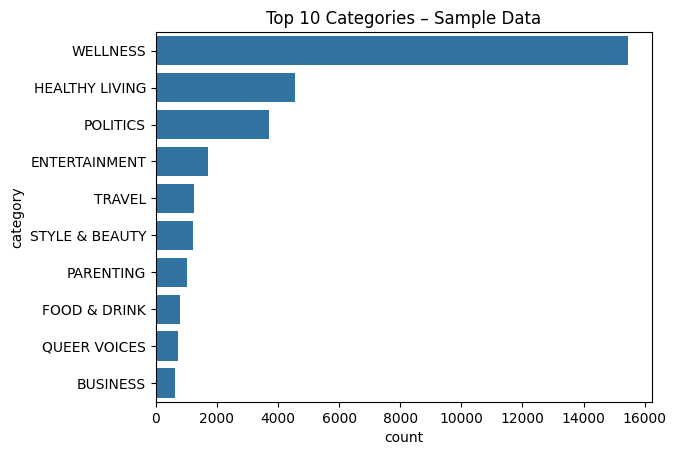

In [28]:
sns.countplot(y="category", data=df_sample,
              order=df_sample.category.value_counts().iloc[:10].index).set_title('Top 10 Categories – Sample Data')

Plot distribution of wellness vs. non-wellness categories in sample data.

Text(0, 0.5, 'Category')

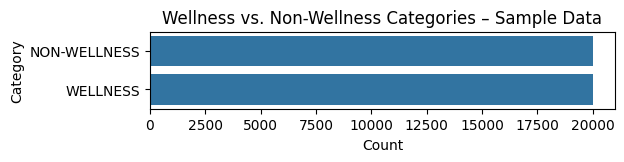

In [29]:
# Count wellness vs. non-wellness categories
well_counts = pd.DataFrame({'category': ['NON-WELLNESS', 'WELLNESS'], 'count': df_sample.wellness.value_counts()})

# Plot distribution
plt.figure(figsize=(6, 1))
sns.barplot(x = 'count', y = 'category', data = well_counts).set_title('Wellness vs. Non-Wellness Categories – Sample Data')
plt.xlabel('Count')
plt.ylabel('Category')

# 5. Model Building

## Create Preprocessed Data
Create a transformer to use in the model. Going to be using `distilbert-base-uncased` due to its ability to strike a balance between size and performance.

In [30]:
tf.keras.backend.clear_session()
t = ktext.Transformer('distilbert-base-uncased',
                     maxlen = 512,
                     class_names = well_cat)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenize and preprocess the input text (`final_text`) for k-train.

In [31]:
train, val, preprocess = ktext.texts_from_df(train_df = df_sample,
                                             text_column = 'final_text',
                                             label_columns = ['wellness'],
                                             val_df = None,
                                             max_features = 20000,
                                             maxlen = 512,
                                             val_pct = 0.1,
                                             ngram_range = 1,
                                             preprocess_mode = 'distilbert')

['not_wellness', 'wellness']
       not_wellness  wellness
4329            1.0       0.0
24766           0.0       1.0
411             1.0       0.0
19586           1.0       0.0
34228           0.0       1.0
['not_wellness', 'wellness']
       not_wellness  wellness
4440            1.0       0.0
3024            1.0       0.0
25719           0.0       1.0
11461           1.0       0.0
5135            1.0       0.0
preprocessing train...
language: en
train sequence lengths:
	mean : 19
	95percentile : 31
	99percentile : 37


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 19
	95percentile : 31
	99percentile : 36


## Hyperparameter Tuning
Create a classified model and return a k-train Learner instance that can be used to tune and train Keras models. Then, simulate training for different learning rates to find the maximal learning rate.

In [32]:
# Classifier model
model = preprocess.get_classifier()

In [33]:
# Learner instance
learner = ktrain.get_learner(model,
                             train_data = train,
                             val_data = val,
                             batch_size = 16)

In [38]:
# Simulate training
learner.lr_find(max_epochs = 3)

simulating training for different learning rates... this may take a few moments...
Epoch 1/3
2250/2250 [==============================] - 1948s 853ms/step - loss: 0.4399 - accuracy: 0.7966
Epoch 2/3
2250/2250 [==============================] - 1922s 851ms/step - loss: 0.5784 - accuracy: 0.6464
Epoch 3/3
2250/2250 [==============================] - 1456s 644ms/step - loss: 10049.8369 - accuracy: 0.4981


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


Three possible suggestions for LR from plot:
	Longest valley (red): 2.83E-06
	Min numerical gradient (purple): 4.41E-05
	Min loss divided by 10 (omitted from plot): 7.38E-06


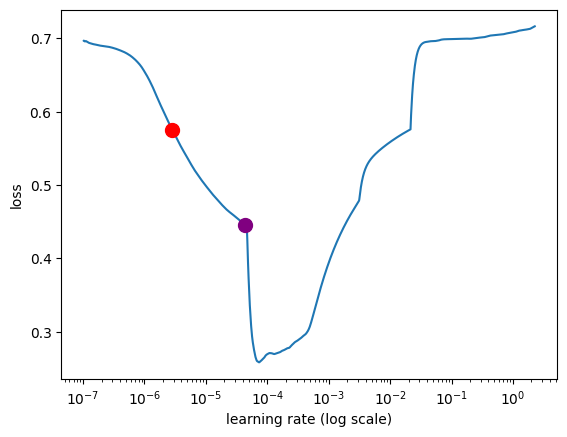

In [42]:
# Plot Loss vs. Learning Rate
learner.lr_plot(suggest = True)

In [43]:
# Learning rate estimates
learner.lr_estimate()

(4.407051e-05, 7.381557225016877e-06, 2.8304266e-06)

Based on the learning rate plot and learning rate estimates, a learning rate of $3e^{-5}$.

# 6. Model Training

In [45]:
# Train model with optimal learning rate
history = learner.autofit(
    lr = 3e-5,
    epochs = 12,
    early_stopping = True)



begin training using triangular learning rate policy with max lr of 3e-05...
Epoch 1/12
2250/2250 [==============================] - 1967s 870ms/step - loss: 0.2594 - accuracy: 0.8976 - val_loss: 0.2299 - val_accuracy: 0.9105
Epoch 2/12
2250/2250 [==============================] - 1946s 865ms/step - loss: 0.1669 - accuracy: 0.9382 - val_loss: 0.2321 - val_accuracy: 0.9128
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


# 7. Model Validation

View classifcation report.

In [46]:
validation = learner.validate(val_data = val,
                              print_report = True,
                              class_names = well_cat)

125/125 [==============================] - 18s 126ms/step
                precision    recall  f1-score   support

HEALTHY LIVING       0.93      0.89      0.91      2069
      WELLNESS       0.89      0.93      0.91      1931

      accuracy                           0.91      4000
     macro avg       0.91      0.91      0.91      4000
  weighted avg       0.91      0.91      0.91      4000



View confusion matrix.

In [47]:
validation

array([[1848,  221],
       [ 137, 1794]])

# 8. Model Evaluation

* Performance Metrics

* Dataset Prediction

## Performance Metrics
Calculate model performance metrics from confusion matrix.

In [48]:
TP = validation[1, 1]
TN = validation[0, 0]
FP = validation[0, 1]
FN = validation[1, 0]

In [58]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
error = (FP + FN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
false_positive_rate = FP / (TN + FP)
precision = TP / (TP + FP)
f1 = (sensitivity + precision) / 2

In [59]:
print('Accuracy:\t\t', round(accuracy, 4)*100, '%')
print('Classification Error:\t', round(error, 4)*100, '%')
print('Sensitivity / Recall:\t', round(sensitivity, 4)*100, '%')
print('False Positive Rate:\t', round(false_positive_rate, 4)*100, '%')
print('Precision:\t\t', round(precision, 4)*100, '%')
print('F1 Score:\t\t', round(f1, 4)*100, '%')

Accuracy:		 91.05 %
Classification Error:	 8.95 %
Sensitivity / Recall:	 92.91 %
False Positive Rate:	 10.68 %
Precision:		 89.03 %
F1 Score:		 90.97 %


## Dataset Prediction
Create predictions for all articles in original dataset to evaluate model accuracy.

In [52]:
#learner.save_model("%s/distilbertmodel_learner" % DATA_DIR)
# Predictor model
predictor = ktrain.get_predictor(learner.model, preproc = preprocess)

In [53]:
# Create predictions for all articles in original dataset
val_probs = predictor.predict(list(df['final_text']), return_proba = True)

In [54]:
# Add predictions to dataframe
df['pred_proba'] = val_probs[:,1]
df['pred'] = np.where(df['pred_proba']>0.5, 1, 0)
df['pred_acc'] = (df['pred'] == df['wellness'])
df.head()

,category,headline,authors,link,short_description,date,full_text,wellness,text_length,word_count,clean_text,final_text,pred_proba,pred,pred_acc
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,141,31,mass shootings texas last week tv left husband...,mass shooting texas last week tv left husband ...,0.014411,0,True
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,100,22,smith joins diplo nicky jam world cups officia...,smith join diplo nicky jam world cup official ...,0.033903,0,True
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0,135,26,hugh grant marries first time age actor longti...,hugh grant marries first time age actor longti...,0.005383,0,True
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0,156,27,jim carrey blasts castrato adam schiff democra...,jim carrey blast castrato adam schiff democrat...,0.002758,0,True
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0,159,32,julianna margulies uses donald trump poop bags...,julianna margulies us donald trump poop bag pi...,0.358558,0,True


Evaluate model prediction accuracy on original data.

In [55]:
pd.concat([df['pred_acc'].value_counts(), df['pred_acc'].value_counts(normalize = True)], axis=1, keys=['Count', 'Percentage'])

,Count,Percentage
True,165106,0.911483
False,16034,0.088517


The model accurately predicted 91% of articles in the data.

Text(0, 0.5, 'Category')

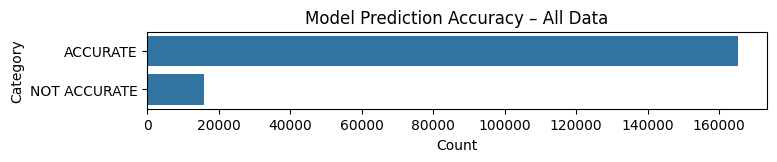

In [57]:
# Count accurate vs. not accurate predictions
acc_counts = pd.DataFrame({'category': ['ACCURATE', 'NOT ACCURATE'], 'count': df['pred_acc'].value_counts()})

# Plot distribution
plt.figure(figsize=(8, 1))
sns.barplot(x = 'count', y = 'category', data = acc_counts).set_title('Model Prediction Accuracy – All Data')
plt.xlabel('Count')
plt.ylabel('Category')

# 9. Results and Conclusion

The table below compares the current model to the benchmark model from the assignment.

|    Metric | Benchmark Model | Current Model | Improvement (%) |
|----------:|:---------------:|:-------------:|:---------------:|
| Precision |       0.85      |      0.89     |       4.71      |
|    Recall |       0.89      |      0.93     |       4.49      |
|  F1-Score |       0.87      |      0.91     |       4.60      |
|  Accuracy |       0.86      |      0.91     |       5.81      |

The current model performed, on average, 5% better across all metrics than the benchmark model:

* **Precision:** The current model achieved a precision score of 0.89, meaning that out of all the positive predictions made by the model, 89% were correct. This indicates the model's stellar ability to avoid false positives, making it highly precise at predicting positive outcomes.

* **Recall:** The model had a recall score of 0.93, indicating that 93% of true positive instances, out of all actual positive instances, were correctly classified. The model shows a high recall, suggesting that it is effective at capturing the majority of positive instances and has a low rate of false negatives.

* **F1-Score:** With an F1-score of 0.91, the current model strikes a good balance between the metrics of precision and recall. Specifically, this suggests that the model is achieving high precision (correctly identifying positive instances when it predicts positive) and high recall (capturing a large portion of actual positive instances).

* **Accuracy:** An accuracy score of 0.91 means that the model correctly predicted the outcome for approximately 91% of the instances in the dataset. This indicates that the model is performing well in terms of overall correctness.

Overall, the current model performs well for the contextual advertising task of predicting the probability that a news story is about health and wellness. The deep learning algorithm can be confidently used for Theragun's media campaign to identify as many news articles that mention health and wellness as possible.